In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:
import glob
import posixpath

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import gaussian_filter

from tf_unet.inno_data import InnH5PCards
from tf_unet import unet

In [3]:
INPUT_SIZE = 572
ROOT_PATH = "/srv/tasks/IMAGE-1474-Plastic-Cards-Semantic-Segmentation/data-mounts/"
IMG_H5_125 = posixpath.join(ROOT_PATH, "pcards-alpha-0.15-0.6-125x125/images-test.h5")
IMG_H5_572 = posixpath.join(ROOT_PATH, "pcards-alpha-0.15-0.6-572x572/images-test.h5")
ANN_H5_125 = posixpath.join(ROOT_PATH, "pcards-alpha-0.15-0.6-125x125/annotations-test.h5")
ANN_H5_572 = posixpath.join(ROOT_PATH, "pcards-alpha-0.15-0.6-572x572/annotations-test.h5")
IMG_DF = "images"
ANN_DF = "annotations"

search_path = "/srv/tasks/IMAGE-1474-Plastic-Cards-Semantic-Segmentation/data-real/*.png" 
paths = glob.glob(search_path)

In [4]:
#Crop an image to the net out image size
def visible(image):
    return image[92:-92,92:-92]

In [5]:
def patch(path, crop, out_size=(572, 572)):
    image = np.array(Image.open(path), np.float32)
    patch = image[crop[0]:crop[1], crop[2]:crop[3]]
    if patch.shape[:2] != out_size:
        patch = cv2.resize(patch, out_size, interpolation=cv2.INTER_LINEAR)
    patch = np.clip(np.fabs(patch), 0, 255)
    patch -= np.amin(patch)
    patch /= np.amax(patch)
    return patch

In [6]:
def show_results(images, results):
    assert len(images) == len(results)
    n_rows = len(results)
    n_cols = 3
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    ax = np.ravel(ax)
    for i, result in enumerate(results):
        ax[i*n_cols].imshow(visible(images[i, ...]), aspect="equal")
        ax[i*n_cols].set_title("Image")
        ax[i*n_cols+1].imshow(result[..., 0], aspect="equal", cmap=plt.cm.gray)
        ax[i*n_cols+1].set_title("Score map BG")
        ax[i*n_cols+2].imshow(result[..., 1], aspect="equal", cmap=plt.cm.gray)
        ax[i*n_cols+2].set_title("Score map FG")

## Image 125 × 125 with defect and masks (bg, fg)

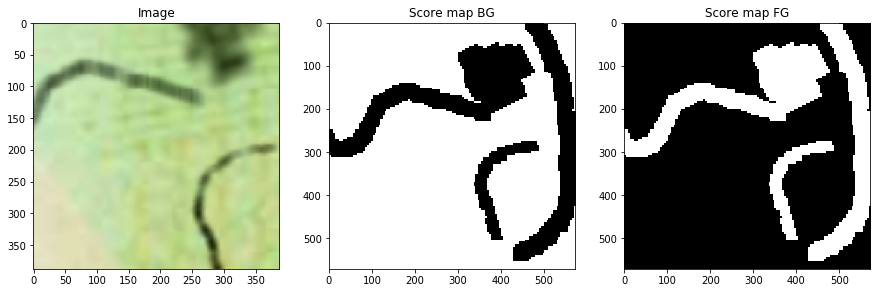

In [7]:
generator_125 = InnH5PCards(INPUT_SIZE, IMG_H5_125, IMG_DF, ANN_H5_125, ANN_DF)
image, label = generator_125(1)
show_results(image, label)

In [8]:
net_125 = unet.Unet(
    channels=generator_125.channels, n_class=generator_125.n_class, layers=5,
    features_root=16, summaries=True,
    cost_kwargs={"class_weights": [0.5, 0.5]})

2018-12-13 14:19:56,207 Layers 5, features 16, filter size 3x3, pool size: 2x2


In [9]:
x_test, y_test = generator_125(3)
preds_125 = net_125.predict("../scripts/unet_trained/model.ckpt", x_test)

INFO:tensorflow:Restoring parameters from ../scripts/unet_trained/model.ckpt


2018-12-13 14:19:59,869 Restoring parameters from ../scripts/unet_trained/model.ckpt
2018-12-13 14:19:59,982 Model restored from file: ../scripts/unet_trained/model.ckpt


## Results of model trained on 125×125 images upsaceld to 572×572

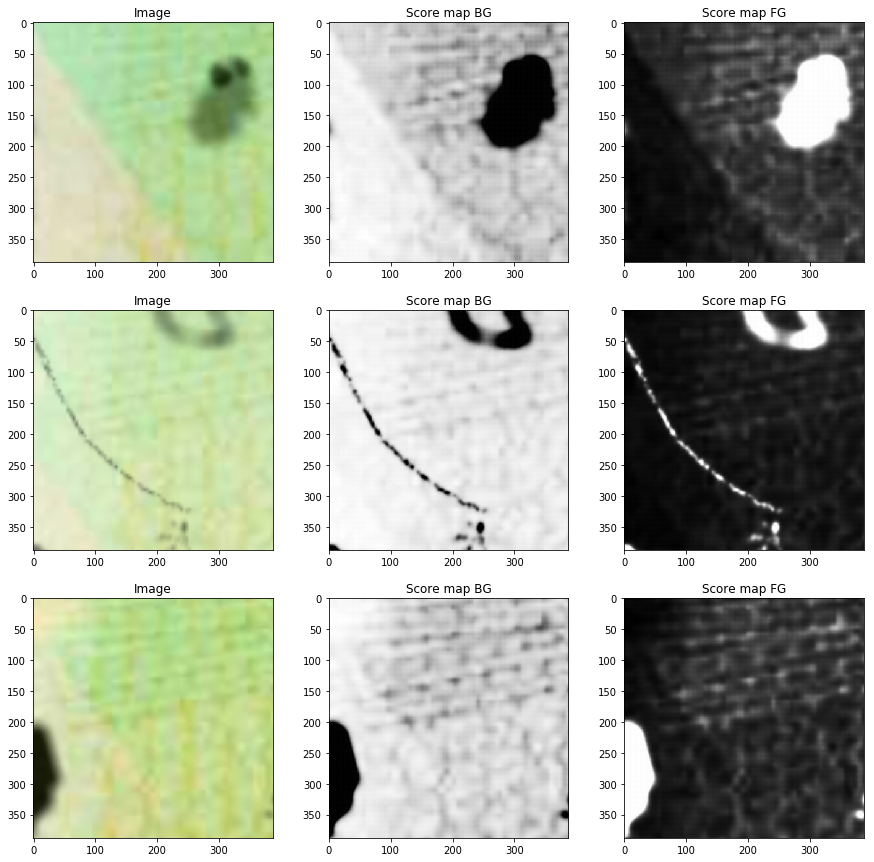

In [10]:
show_results(x_test, preds_125)

In [11]:
patches_125 = [patch(path, (700,825,700,825)) for path in paths]
arr_125 = np.asarray(patches_125)
#preds_125 = net_125.predict("../experiments/01-125x125/unet_trained-2/model.ckpt", arr_125)
preds_125 = net_125.predict("../scripts/unet_trained/model.ckpt", arr_125[:3])

INFO:tensorflow:Restoring parameters from ../scripts/unet_trained/model.ckpt


2018-12-13 14:20:05,105 Restoring parameters from ../scripts/unet_trained/model.ckpt
2018-12-13 14:20:05,172 Model restored from file: ../scripts/unet_trained/model.ckpt


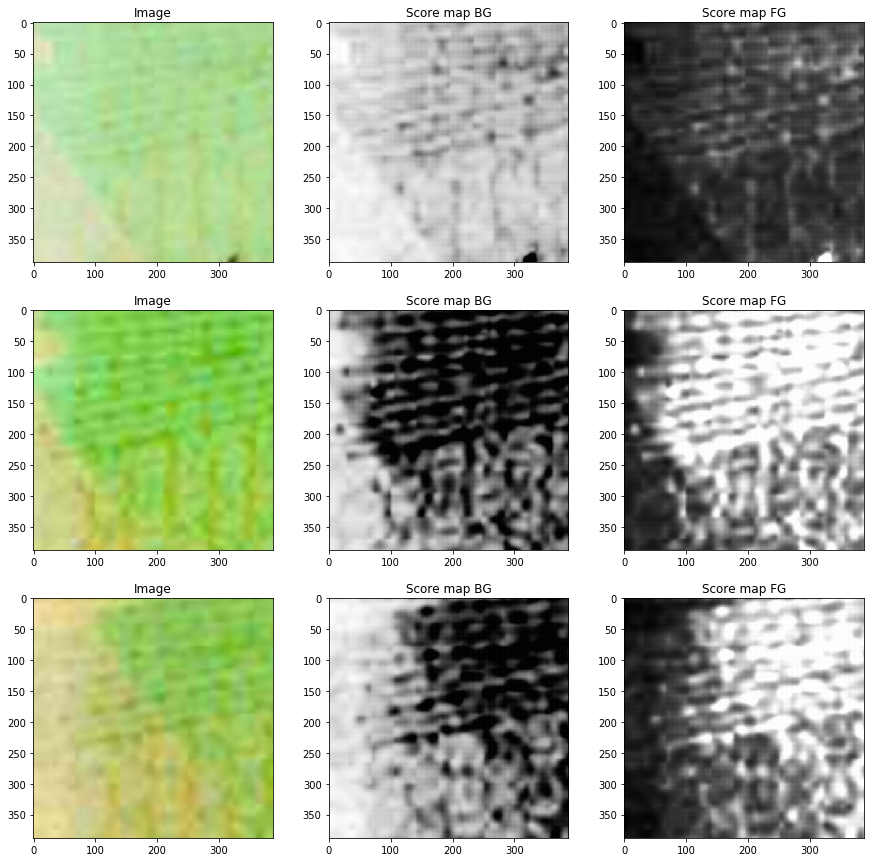

In [12]:
show_results(arr_125[:3], preds_125)

## Image 572 × 572 with defect and masks (bg, fg)

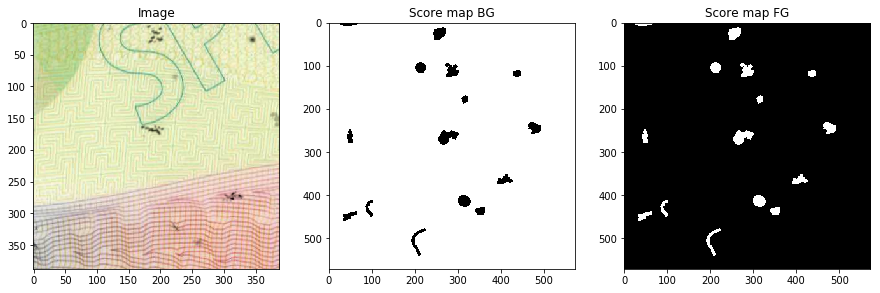

In [13]:
generator_572 = InnH5PCards(INPUT_SIZE, IMG_H5_572, IMG_DF, ANN_H5_572, ANN_DF)
image, label = generator_572(1)
show_results(image, label)

In [14]:
net_572 = unet.Unet(
    channels=generator_572.channels, n_class=generator_572.n_class, layers=5,
    features_root=16, summaries=True,
    cost_kwargs={"class_weights": [0.5, 0.5]})
x_test, y_test = generator_572(3)
prediction = net_572.predict("../experiments/unet_trained-2/model.ckpt", x_test)
print(x_test.shape)

2018-12-13 14:20:08,611 Layers 5, features 16, filter size 3x3, pool size: 2x2


INFO:tensorflow:Restoring parameters from ../experiments/unet_trained-2/model.ckpt


2018-12-13 14:20:11,043 Restoring parameters from ../experiments/unet_trained-2/model.ckpt
2018-12-13 14:20:11,122 Model restored from file: ../experiments/unet_trained-2/model.ckpt


(3, 572, 572, 3)


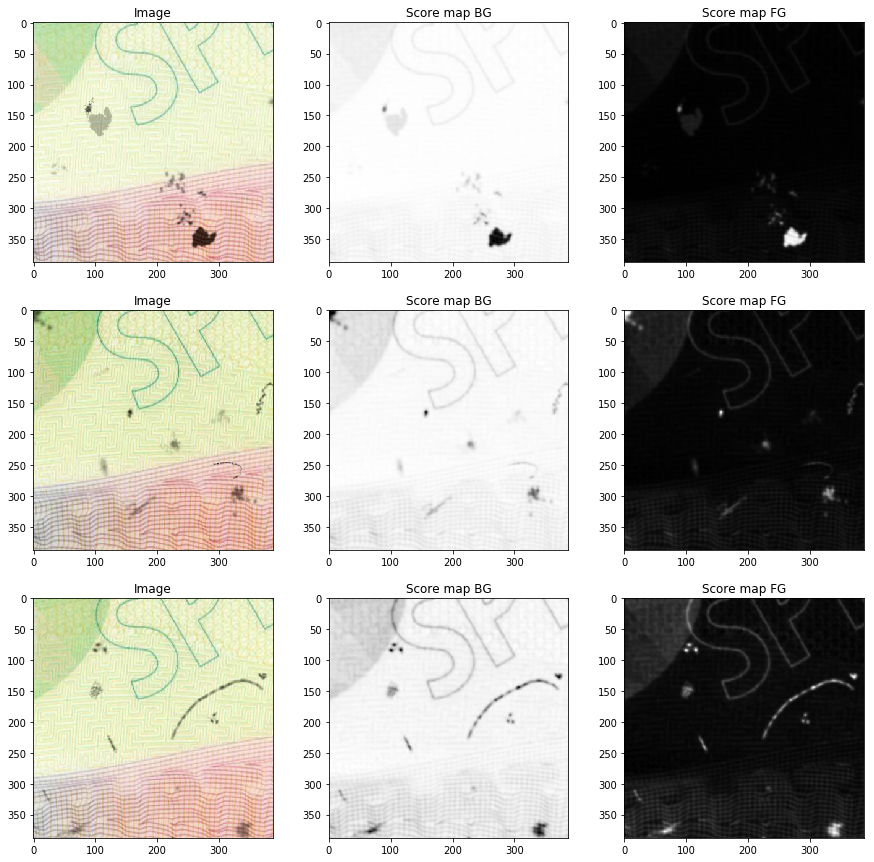

In [15]:
show_results(x_test, prediction)

In [16]:
patches_572 = [patch(path, (650,1222,650,1220)) for path in paths]
arr_572 = np.asarray(patches_572)
predicts_572 = net_572.predict("../experiments/unet_trained-2/model.ckpt", arr_572)

INFO:tensorflow:Restoring parameters from ../experiments/unet_trained-2/model.ckpt


2018-12-13 14:20:14,221 Restoring parameters from ../experiments/unet_trained-2/model.ckpt
2018-12-13 14:20:14,306 Model restored from file: ../experiments/unet_trained-2/model.ckpt


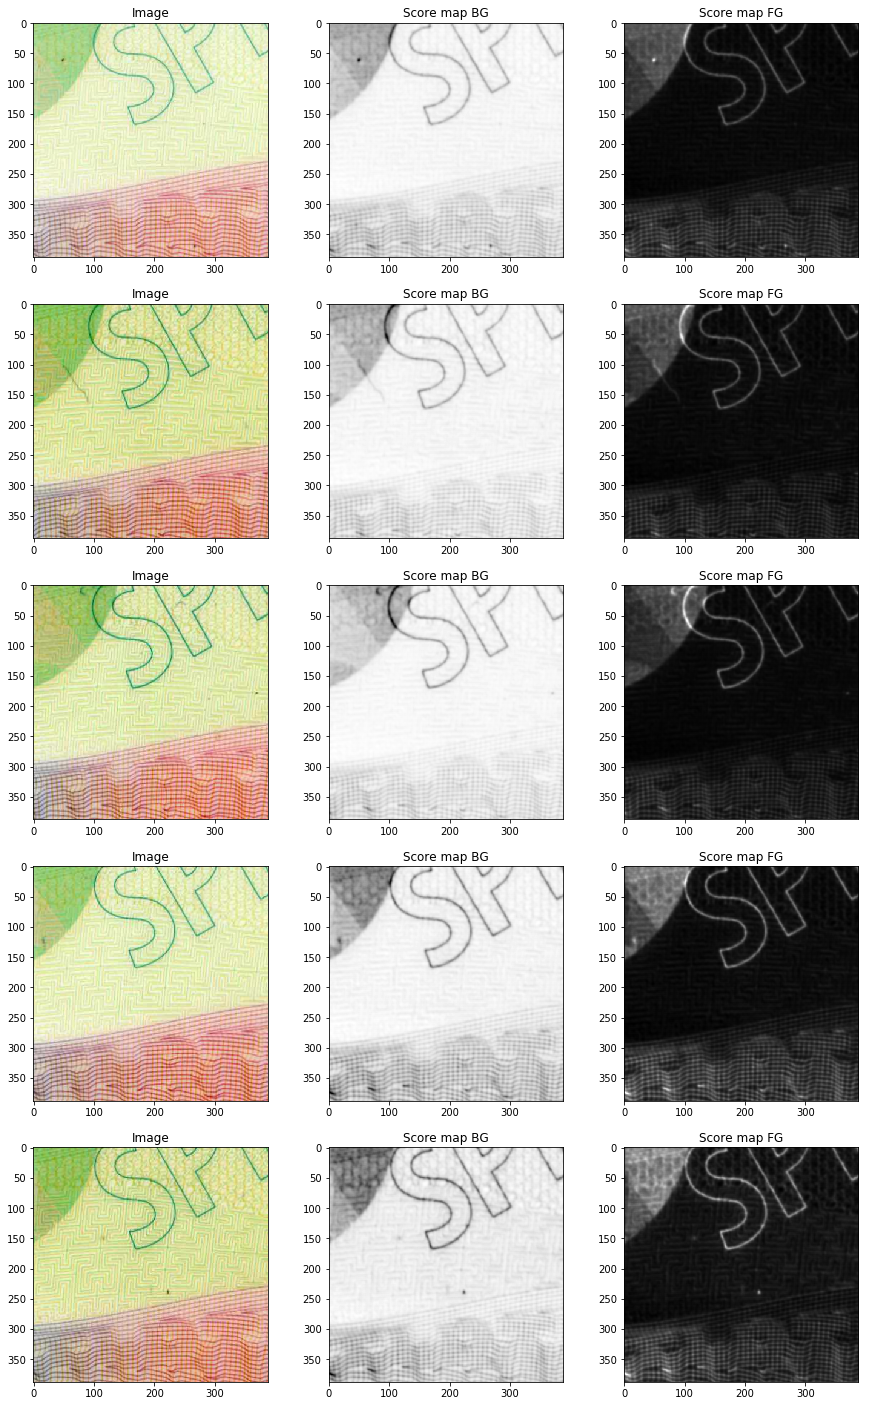

In [17]:
show_results(arr_572, predicts_572)